In [5]:
import cdsapi
import numpy as np
import pandas as pd
import xarray as xr
from shapely import geometry
from pathlib import Path
from typing import Union
from datetime import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from phase_o_matic.preprocess import get_vapor_partial_pressure, convert_pressure_to_pascals, interpolate_to_geopotential

from era import initconst
constants = initconst()

In [41]:
from scipy import interpolate
def interpolate_to_geopotential(dataset: xr.Dataset, min_alt = -200, n_heights = 300) -> xr.Dataset:
    """
    Interpolate vapor pressure, air pressure, and temperatures from pressure level coordinates
    to geopotential height coordinates. Cubic spline is used for each lat and lon.

    Args:
    dataset: xarray dataset with vpr, t data variables, and with level as coordinate
    min_alt: [-200] minimum height in meters to interpolate form
    n_heights: [300] number of evenly space heights to use in interpolating

    Returns:
    interpolated_ds: xarray dataset with coordinate "heights" of n_heights and data variables
    "temperature", "pressure", and "vapor_pressures" interpolated to each geopotential height. 
    """

    assert 'vpr' in dataset.data_vars, "No vapor pressure data. Please calculate first."
    assert 'level' in dataset.coords, "Need pressure level as a coordinate."
    # calculate height range from -200 meters to highest potential height
    maxAlt = dataset['z'].max().round()
    heights = np.linspace(min_alt, maxAlt, n_heights)

    # create empty array to hold interpolated data
    new_size = (1, dataset['longitude'].size, dataset['latitude'].size, n_heights)

    interpolated_ds = xr.Dataset(
            {
                'air_pressure': (['time','longitude', 'latitude','height'], np.zeros(new_size), dataset['level'].attrs),
                'temperature': (['time', 'longitude', 'latitude','height'], np.zeros(new_size), dataset['t'].attrs),
                'vapor_pressure': (['time', 'longitude', 'latitude','height'], np.zeros(new_size), dataset['vpr'].attrs),
            },  
            coords = {
                "longitude" : (["longitude"], dataset['longitude'].data, dataset['longitude'].attrs),
                "latitude" : (["latitude"], dataset['latitude'].data, dataset['latitude'].attrs),
                "height" : (["height"], heights, {'units' :'meters', 'long_name' :'altitude'}),
                "time" : (["time"], dataset['time'].data, {'long_name' :'time'}),
            },
            attrs=dataset.attrs
        )

    # scipy 1d interpolate won't accept 2d array as y values so have to iterate
    for lon in dataset.longitude:
        for lat in dataset.latitude:

            # get geopotential heights at this lat and long
            hx = dataset['z'].isel(time = 0).sel(latitude = lat, longitude = lon)

            # interpolate pressure levels to pressure at each height
            hy = dataset['level']
            # make cubic interpolator
            tck = interpolate.interp1d(hx,hy,axis = -1,kind='cubic',fill_value="extrapolate")
            # interpolate what pressure would occur at each height
            interpolated_pressure = tck(heights)
            # add to interpolated dataset at correct lat and long
            interpolated_ds['air_pressure'].loc[{'latitude': lat, 'longitude': lon}] =  xr.DataArray(interpolated_pressure, coords = [heights], dims = 'height')

            # interpolate temperatures to temperature at each height level
            hy = dataset['t'].isel(time = 0).sel(latitude = lat, longitude = lon).data
            tck = interpolate.interp1d(hx,hy,axis = -1,kind='cubic',fill_value="extrapolate")
            interpolated_temperatures = tck(heights)
            interpolated_ds['temperature'].loc[{'latitude': lat, 'longitude': lon}] =  xr.DataArray(interpolated_temperatures, coords = [heights], dims = 'height')

            # interpolate vapor pressures to vapor pressures at each height level
            hy = dataset['vpr'].isel(time = 0).sel(latitude = lat, longitude = lon).data
            tck = interpolate.interp1d(hx,hy,axis = -1,kind='cubic',fill_value="extrapolate")
            interpolated_vapor= tck(heights)
            interpolated_ds['vapor_pressure'].loc[{'latitude': lat, 'longitude': lon}] =  xr.DataArray(interpolated_vapor, coords = [heights], dims = 'height')
        
    return interpolated_ds

In [42]:
era = xr.open_dataset('../data/ERA5_2020-01-03T20:00_-116.0_45.0_-115.0_46.0.nc')
ds = convert_pressure_to_pascals(era)
era = get_vapor_partial_pressure(era)
new = interpolate_to_geopotential(era)

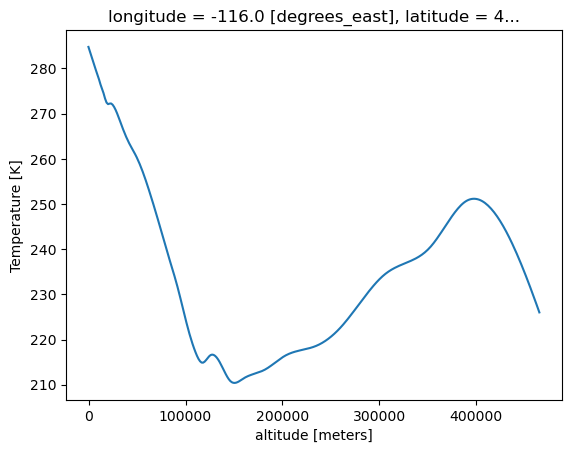

In [46]:
new.isel(time = 0, longitude = 0, latitude = 3)['temperature'].plot()